# Ensemble 

this is the exercise of ensemble method, copy from [Introduction to python ensemble](https://www.dataquest.io/blog/introduction-to-ensembles/)

In [1]:
import os     

In [2]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline 

In [4]:
# import data , 
SEED = 222 
np.random.seed(SEED)

df = pd.read_csv('input.csv')

In [5]:
## training test set 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [6]:
def get_train_test(test_size=0.95):
    '''split data into train/test sets'''
    y = 1*(df.cand_pty_affiliation =='REP')
    X = df.drop(['cand_pty_affiliation'], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

## 
print("\nExample Data:")
df.head()


Example Data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [7]:
df.cand_pty_affiliation.value_counts(normalize=True)

DEM    0.75608
REP    0.24392
Name: cand_pty_affiliation, dtype: float64

### DecisionTreeClassifier

In [8]:
# !pip install pydotplus ## install pydotplus 

In [9]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [10]:
def print_graph(clf, feature_names):
    '''print decision tree'''
    graph = export_graphviz(
        clf,
        label='root',
        proportion=True,
        out_file=None,
        feature_names=feature_names,
        class_names={0:'D',1:'R'},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

In [11]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:,1]
print('Decision tree ROC-AUC score: {:.3f}'.format(roc_auc_score(ytest,p)))

Decision tree ROC-AUC score: 0.672


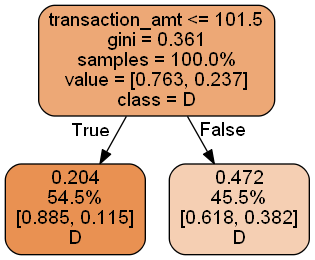

In [12]:
print_graph(t1,xtrain.columns)

In [13]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:,1]

print('Decision tree ROC-AUC score:{:.3f}'.format(roc_auc_score(ytest,p)))

Decision tree ROC-AUC score:0.751


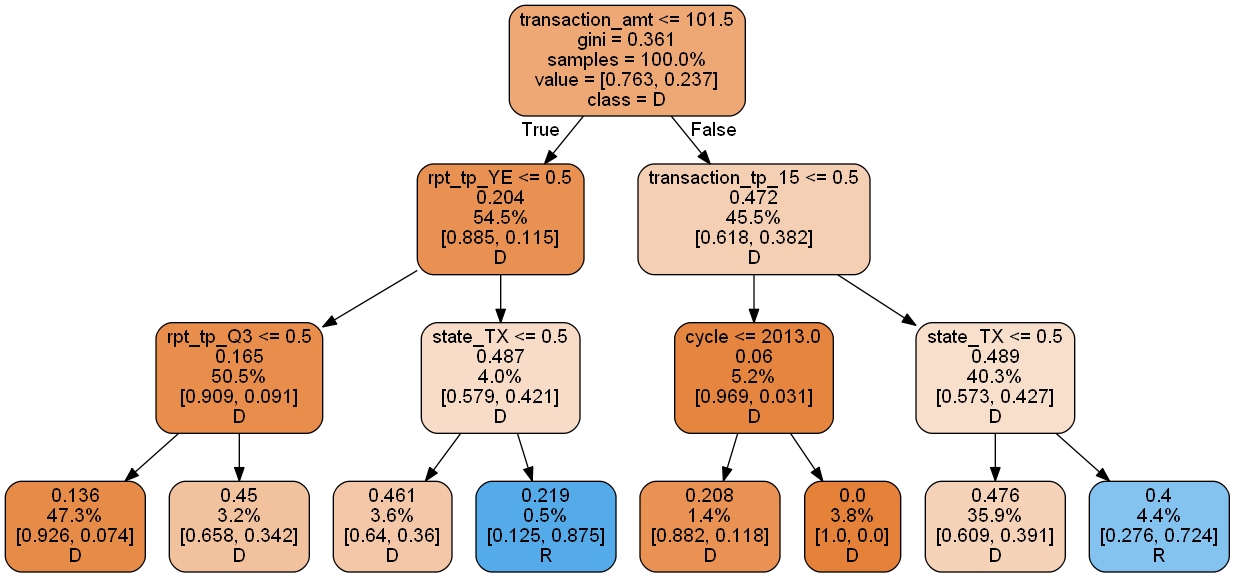

In [14]:
print_graph(t2, xtrain.columns)

Decision tree ROC-AUC score: 0.740


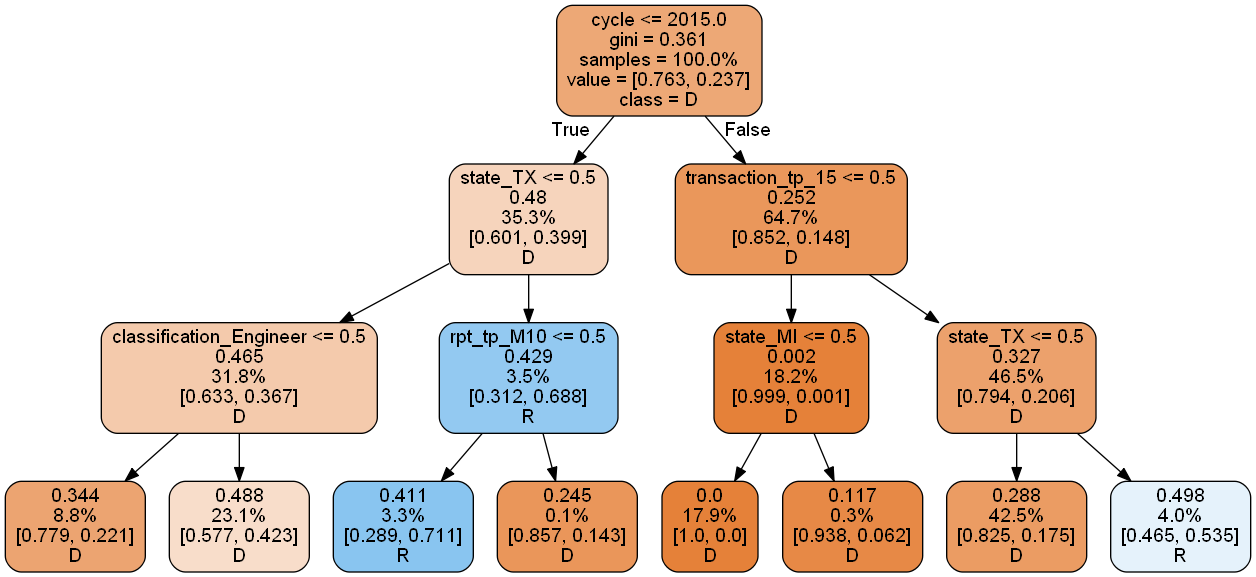

In [15]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

In [16]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


In [17]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.783


### Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))


Average of decision tree ROC-AUC score: 0.844


# To build an ensemble of various model

In [19]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [20]:
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [21]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
random forest... done
gbm... done
naive bayes... done
logistic... done
mlp-nn... done
svm... done
knn... done
Done.

Scoring models.
random forest             : 0.844
gbm                       : 0.878
naive bayes               : 0.803
logistic                  : 0.857
mlp-nn                    : 0.851
svm                       : 0.850
knn                       : 0.779
Done.



In [22]:
P.head()

,random forest,gbm,naive bayes,logistic,mlp-nn,svm,knn
0,0.3,0.265998,5.020798e-10,0.149802,0.156115,0.345439,0.333333
1,0.0,0.017165,1.085367e-68,0.002533,0.010601,0.007051,0.000000
2,0.2,0.328002,6.701134e-14,0.284235,0.226278,0.557809,0.333333
3,0.0,0.024914,2.862588e-62,0.024563,0.049854,0.043589,0.000000
4,0.0,0.017396,1.020511e-61,0.004619,0.027849,0.004205,0.000000


In [23]:
P.corr()

,random forest,gbm,naive bayes,logistic,mlp-nn,svm,knn
random forest,1.000000,0.777899,0.445388,0.733332,0.700009,0.708069,0.621119
gbm,0.777899,1.000000,0.533438,0.868336,0.874511,0.781459,0.645926
naive bayes,0.445388,0.533438,1.000000,0.594652,0.551825,0.454312,0.332933
logistic,0.733332,0.868336,0.594652,1.000000,0.805134,0.742293,0.560337
mlp-nn,0.700009,0.874511,0.551825,0.805134,1.000000,0.735187,0.593919
svm,0.708069,0.781459,0.454312,0.742293,0.735187,1.000000,0.705395
knn,0.621119,0.645926,0.332933,0.560337,0.593919,0.705395,1.000000


In [24]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


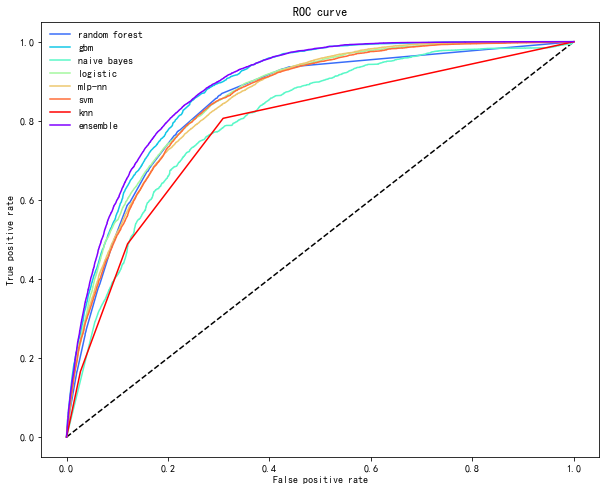

In [25]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")


### underrepresented model

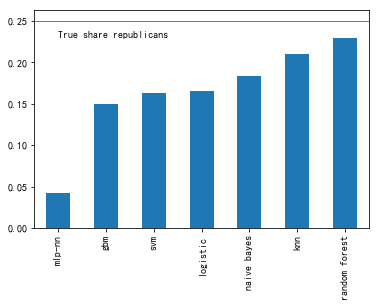

In [35]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

In [36]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


# Learn to combine

### Step1 : define a library of base learners

In [ ]:
base_learner = get_models()

### Step 2: define a meta learner

In [39]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

### Step 3: define a procedure for generating train and test sets

In [40]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

### step4.train the base learners on a training set

In [46]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [56]:
train_base_learners(base_learner, xtrain_base, ytrain_base)

Fitting models.
random forest... done
gbm... done
naive bayes... done
logistic... done
mlp-nn... done
svm... done
knn... done


### step5. generate base learner predictions

In [53]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

In [57]:
P_base = predict_base_learners(base_learner, xpred_base)

Generating base learner predictions.
random forest... done
gbm... done
naive bayes... done
logistic... done
mlp-nn... done
svm... done
knn... done


### step6. train meta- learner

In [60]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=222, subsample=0.5, verbose=0,
              warm_start=False)

In [65]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [67]:
P_pred, p = ensemble_predict(base_learner, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))


Generating base learner predictions.
random forest... done
gbm... done
naive bayes... done
logistic... done
mlp-nn... done
svm... done
knn... done

Ensemble ROC-AUC score: 0.881


## Stacking 

Training with cross-validation

In [88]:
import pdb

In [91]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)
#         pdb.set_trace()
        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [68]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))


Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.889
